In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from pi_py_darknet.darknet import initialize, detect
import cv2

In [3]:
from picamera import PiCamera
import time

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt


In [ ]:
net, meta = initialize()

In [5]:
camera = PiCamera()
camera.rotation = 180
camera.resolution = (1024, 768)
time.sleep(2)

<IPython.core.display.Javascript object>


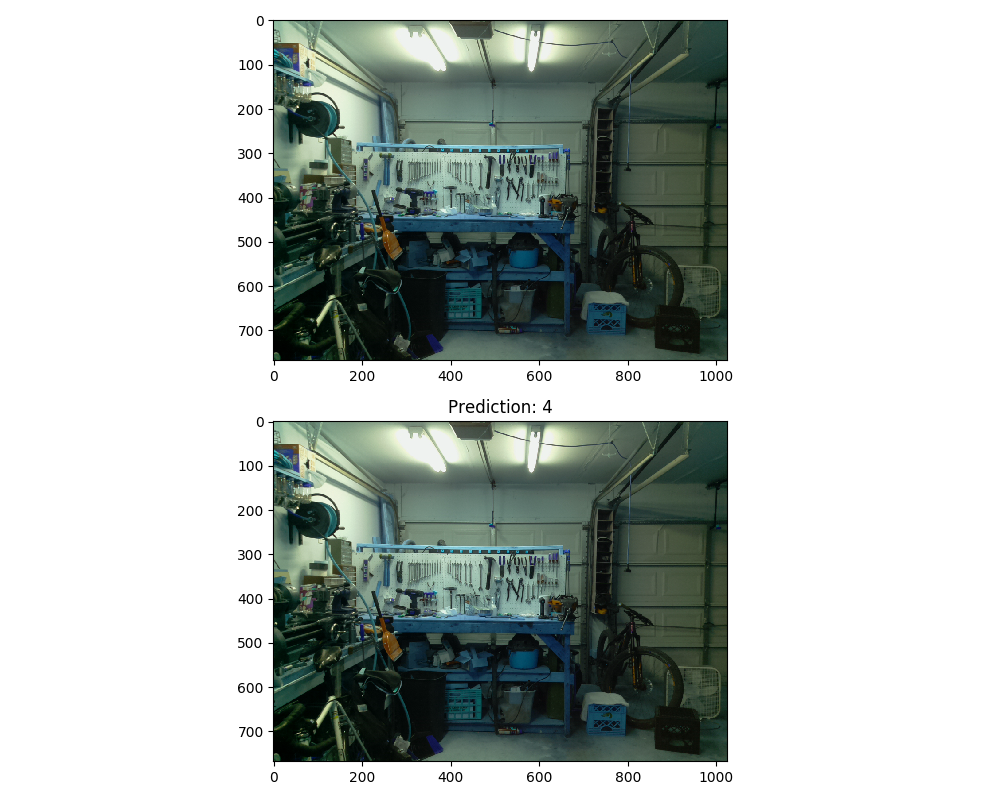

In [6]:
fig = plt.figure(figsize=[10,8])
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

In [7]:
def detect_people(img_filename):
#     results = darknet.detect(net, meta, b"foo.jpg")
    results = darknet.detect(net, meta, bytes(img_filename, 'utf-8'))
    
    people = []
    
    for cat, score, bounds in results:
        if cat == 'person':
            people.append((cat, score, bounds))
            
    return people



In [8]:
%load_ext line_profiler

In [9]:
def run():
    n = 0
    predictions = []
    while n < 5:

        img_filename = 'capture.jpg'
        camera.capture(img_filename)

        img = cv2.imread(img_filename)

#         ax1.imshow(img)
#         fig.canvas.draw()

        people = detect_people(img_filename)

        for cat, score, bounds in people:
            x, y, w, h = bounds
            print(x, y, w, h)
            
            cv2.rectangle(img, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), (255, 0, 0), thickness=2)
            cv2.circle(img, (x, y))
            label = '{}:{:06.3f}'.format(str(cat.decode("utf-8")), score*100)
            cv2.putText(img,label,(int(x),int(y)),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,0))


#         ax2.imshow(img)
#         plt.tight_layout()
#         plt.title('Prediction: {}'.format(n))
#         fig.canvas.draw()

        cv2.imwrite('results/predicted_{}.png'.format(n), img)
        predictions.append(people)
        
        print(n, len(people))

        n += 1

In [10]:
run()

0 0
1 0
2 0
3 0
4 0


In [17]:
%lprun -f run run()

0 0
1 0
2 0
